In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import statsmodels.api as sm
import statsmodels.formula.api as smf
RANDOM_STATE = 42

ModuleNotFoundError: No module named 'kmodes'

In [46]:
pd.set_option('display.max_columns', None)

In [48]:
def format_lenght(date):
    return date[0]
def K_Prototypes(X):
    kproto_4 = KPrototypes(n_clusters=4, init='Huang', verbose=0, random_state=42, n_jobs=-1)
    clusters = kproto_4.fit_predict(X, categorical=[3, 11, 12, 13, 14, 17, 18, 20, 22])
    return clusters

df = pd.read_csv('train.csv')
df = df.drop(columns=['ID','adr'])
df.dropna(subset=['children'], inplace=True)
df['country']=df['country'].fillna(df['country'].value_counts().index[0]) 
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['hotel'] = np.where(df['hotel']=='City Hotel',1,0)
df['arrival_date_full'] = df['arrival_date_year'].astype(str) + "-" + df['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df['arrival_date_day_of_month'].astype(str)
df['arrival_date_full'] = pd.to_datetime(df['arrival_date_full'], format="%Y-%m-%d")
df['status_minus_arrival_date'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
X = df.drop(columns=['is_canceled', 'reservation_status', 'agent', 'company', 'country', 'reservation_status_date', 'arrival_date_full'])
clusters = K_Prototypes(X)
df['clusters'] = clusters
df = pd.get_dummies(df, columns=[ 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type','country'])
x = df.drop(columns=['is_canceled','arrival_date_year','arrival_date_month','reservation_status', 'agent', 'company', 
                 'reservation_status_date', 'arrival_date_full'])
y = df['is_canceled']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=RANDOM_STATE, 
                                                stratify=y, test_size=0.2)

In [49]:
df = pd.read_csv('test.csv')
df = df.drop(columns=['ID'])
#df['agent'] = df['agent'].fillna('No_Agent')
#df['company'] = df['company'].fillna('No_Company')
#df['country'].fillna("unknown", inplace=True)  
#df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['country']=df['country'].fillna(df['country'].value_counts().index[0]) 
df['hotel'] = np.where(df['hotel']=='City Hotel',1,0)
df['arrival_date_full'] = df['arrival_date_year'].astype(str) + "-" + df['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df['arrival_date_day_of_month'].astype(str)
df['arrival_date_full'] = pd.to_datetime(df['arrival_date_full'], format="%Y-%m-%d")
df['status_minus_arrival_date'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
X = df.drop(columns=['agent', 'company', 'country', 'arrival_date_full'])
clusters = K_Prototypes(X)
df['clusters'] = clusters
df = pd.get_dummies(df, columns=['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type','country'])
test = df.drop(columns=['arrival_date_year','arrival_date_month', 'agent', 'company',  'arrival_date_full'])


In [50]:
def missing_col(x_train,x_pred):
    missing_cols = set( x_train.columns ) - set( x_pred.columns )

    for c in missing_cols:
        x_pred[c] = 0

    x_pred = x_pred[x_train.columns]
    return x_pred

In [51]:
x_pred = missing_col(x_train, test)

In [52]:
bc_params = {
    'n_estimators': [45], 
    'max_features': [0.8]
}

# Perform Grid Search
bc_gs = GridSearchCV(BaggingClassifier(random_state=RANDOM_STATE),
                 bc_params,
                 cv = 5,
                 scoring = 'accuracy')
bc = bc_gs.fit(x_train, y_train)

In [53]:
print(f'Best Training Accuracy: {bc.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {bc.score(x_test, y_test)}')

Best Training Accuracy: 0.9944414853662201
Best Testing Accuracy: 0.8980115809024364


In [57]:
y_pred = bc.predict(x_pred)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [58]:
can = pd.read_csv('cancelled')
can['bg'] = y_pred
can.to_csv('cancelled',index=False)

# NN

In [10]:
x_train.shape

(73221, 227)

13023    1
5058     0
1604     1
36792    1
19805    0
        ..
60086    1
89884    0
68538    0
90122    0
76982    0
Name: is_canceled, Length: 73221, dtype: int64

In [13]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(x_train)
X_test_sc = ss.transform(x_test)

# Creating our model's structure
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(227,)))
model.add(Dropout(0.18))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', patience=5) 

# Compiling the model
model.compile(loss='bce',
              optimizer='adam',
              metrics=['binary_accuracy'])

# Fitting the model
history = model.fit(X_train_sc,
                    y_train, 
                    batch_size = 256,
                    validation_data =(X_test_sc, y_test),
                    epochs = 500,
                    verbose = 0,
                    callbacks=[es])

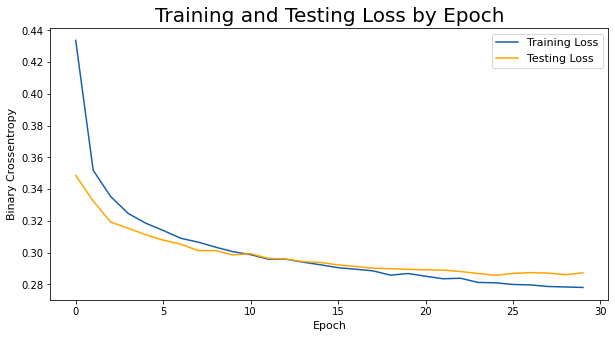

In [14]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Visualizing our training and testing loss by epoch
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11);


In [15]:
train_score = model.evaluate(X_train_sc,
                       y_train,
                       verbose=1)
test_score = model.evaluate(X_test_sc,
                       y_test,
                       verbose=1)
labels = model.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')


573/573 [==============================] - 0s 470us/step - loss: 0.2873 - binary_accuracy: 0.8706

Training Accuracy: 0.8814547657966614
Testing Accuracy: 0.8706434965133667


In [19]:
y_nn = model.predict(x_pred)
y_nn

array([[0.99999934],
       [1.        ],
       [0.6682858 ],
       ...,
       [0.97712314],
       [1.        ],
       [0.6313936 ]], dtype=float32)

# adr

In [23]:
adr_df = pd.read_csv('train.csv')
adr_df = adr_df.drop(columns=['ID','is_canceled','arrival_date_year','arrival_date_month','reservation_status', 'reservation_status_date'])
adr_df.dropna(subset=['children'], inplace=True)
adr_df['country']=adr_df['country'].fillna(adr_df['country'].value_counts().index[0])
adr_df['agent']=adr_df['agent'].fillna(adr_df['agent'].value_counts().index[0])
adr_df['company']=adr_df['company'].fillna(0)
adr_df['children']=adr_df['children'].fillna(adr_df['children'].median())
adr_df['children'] = adr_df['children'].astype(int)   
adr_df['hotel'] = np.where(adr_df['hotel']=='City Hotel',1,0)
adr_df['status_minus_arrival_date'] = adr_df['stays_in_week_nights'] + adr_df['stays_in_weekend_nights']
# X = df.drop(columns=['country','adr'])
# clusters = K_Prototypes(X)
# df['clusters'] = clusters
adr_df.agent = adr_df.agent.astype("category").cat.codes
adr_df.company = adr_df.company.astype("category").cat.codes
adr_df.country = adr_df.country.astype("category").cat.codes
adr_df.meal = adr_df.meal.astype("category").cat.codes
adr_df.market_segment = adr_df.market_segment.astype("category").cat.codes
adr_df.distribution_channel = adr_df.distribution_channel.astype("category").cat.codes
adr_df.reserved_room_type = adr_df.reserved_room_type.astype("category").cat.codes
adr_df.assigned_room_type = adr_df.assigned_room_type.astype("category").cat.codes
adr_df.deposit_type = adr_df.deposit_type.astype("category").cat.codes
adr_df.customer_type = adr_df.customer_type.astype("category").cat.codes
x_adr = adr_df.drop(columns=['adr'])
y_adr = adr_df['adr']
x_train_adr, x_val_adr, y_train_adr, y_val_adr = train_test_split(x_adr, y_adr, random_state=42)

In [24]:
ytrain = np.reshape(y_train_adr.values,(-1,1))
yval = np.reshape(y_val_adr.values,(-1,1))
scaler_x = StandardScaler()
scaler_y = StandardScaler()

xtrain_scale= scaler_x.fit_transform(x_train_adr)
xval_scale=scaler_x.transform(x_val_adr)

ytrain_scale=scaler_y.fit_transform(ytrain)
yval_scale=scaler_y.transform(yval)

In [56]:
rf_params = {
    'n_estimators': [150],  
    'max_depth': [13]
}

# Perform Grid Search
rf_gs = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE),
                 rf_params,
                 cv = 5)
rf = rf_gs.fit(xtrain_scale, ytrain_scale)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 

In [57]:
print(f'Best Training Accuracy: {rf.score(xtrain_scale, ytrain_scale)}')
print(f'Best Testing Accuracy: {rf.score(xval_scale, yval_scale)}')

Best Training Accuracy: 0.8428305199115691
Best Testing Accuracy: 0.8060240553601413


In [26]:
rtg = RandomForestRegressor(n_estimators=150)
rtg_m = rtg.fit(xtrain_scale,ytrain_scale)
print(f'Best Training Accuracy: {rtg_m.score(xtrain_scale, ytrain_scale)}')
print(f'Best Testing Accuracy: {rtg_m.score(xval_scale, yval_scale)}')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Best Training Accuracy: 0.9470359412407718
Best Testing Accuracy: 0.849300185604761


In [27]:
adr_test = pd.read_csv('test.csv')
adr_test = adr_test.drop(columns=['ID','arrival_date_year','arrival_date_month'])
adr_test.dropna(subset=['children'], inplace=True)
adr_test['country']=adr_test['country'].fillna(adr_test['country'].value_counts().index[0])
adr_test['agent']=adr_test['agent'].fillna(adr_test['agent'].value_counts().index[0])
adr_test['company']=adr_test['company'].fillna(0)
adr_test['children']=adr_test['children'].fillna(adr_test['children'].median())
adr_test['children'] = adr_test['children'].astype(int)   
adr_test['hotel'] = np.where(adr_test['hotel']=='City Hotel',1,0)
adr_test['status_minus_arrival_date'] = adr_test['stays_in_week_nights'] + adr_test['stays_in_weekend_nights']
adr_test.agent = adr_test.agent.astype("category").cat.codes
adr_test.company = adr_test.company.astype("category").cat.codes
adr_test.country = adr_test.country.astype("category").cat.codes
adr_test.meal = adr_test.meal.astype("category").cat.codes
adr_test.market_segment = adr_test.market_segment.astype("category").cat.codes
adr_test.distribution_channel = adr_test.distribution_channel.astype("category").cat.codes
adr_test.reserved_room_type = adr_test.reserved_room_type.astype("category").cat.codes
adr_test.assigned_room_type = adr_test.assigned_room_type.astype("category").cat.codes
adr_test.deposit_type = adr_test.deposit_type.astype("category").cat.codes
adr_test.customer_type = adr_test.customer_type.astype("category").cat.codes

In [28]:
adr_test = scaler_x.transform(adr_test)
adr_test

array([[ 0.7202746 , -0.20334735, -1.01029741, ..., -0.2629512 ,
         0.61678056,  1.41876756],
       [ 0.7202746 ,  1.05881274, -1.01029741, ..., -0.2629512 ,
         0.61678056,  4.13513012],
       [-1.38835939, -0.80121265, -1.01029741, ..., -0.2629512 ,
         0.61678056,  1.41876756],
       ...,
       [-1.38835939, -0.75376303,  0.45335969, ..., -0.2629512 ,
         1.92128208, -0.13343962],
       [-1.38835939,  0.897484  ,  0.45335969, ..., -0.2629512 ,
        -0.68772096,  1.41876756],
       [ 0.7202746 , -0.88662198,  0.45335969, ..., -0.2629512 ,
         4.53028511, -0.90954321]])

In [32]:
adr_pred = rtg_m.predict(adr_test)
fin_adr = scaler_y.inverse_transform(adr_pred)
fin_adr

array([ 89.07974018,  65.81875973,  58.88809428, ..., 142.6791027 ,
        84.16416825, 101.58543046])

In [44]:
can_df = pd.read_csv('cancelled')
can_df['0']

0        0
1        1
2        1
3        0
4        1
        ..
27854    0
27855    0
27856    1
27857    0
27858    1
Name: 0, Length: 27859, dtype: int64

In [45]:
final = pd.DataFrame(fin_adr , columns=['adr'])
final['cancel'] = can_df['0']
final['cancel'] = np.where(final['cancel']==0,1,0)

In [46]:
df = pd.read_csv('test.csv')
df['arrival_date_full'] = df['arrival_date_year'].astype(str) + "-" + df['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df['arrival_date_day_of_month'].astype(str)
df['arrival_date_full'] = pd.to_datetime(df['arrival_date_full'], format="%Y-%m-%d")
df['status_minus_arrival_date'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

In [47]:
final['arrival_date_full'] = df['arrival_date_full']
final['status_minus_arrival_date'] = df['status_minus_arrival_date'].astype(int)

In [48]:
final['score'] = (final['status_minus_arrival_date'] * final['cancel'] * final['adr'])
final = final.groupby(final.arrival_date_full).sum().astype(int)
final['score'] = ((final['score'])/10000).astype(int)

In [49]:
final.score.values

array([3, 2, 3, 1, 2, 2, 2, 4, 5, 4, 3, 2, 4, 4, 3, 3, 3, 1, 3, 2, 3, 4,
       3, 3, 1, 1, 2, 5, 6, 3, 4, 3, 2, 3, 4, 4, 3, 4, 2, 2, 4, 2, 3, 4,
       3, 2, 3, 4, 3, 3, 4, 3, 2, 4, 5, 2, 2, 4, 3, 2, 2, 3, 3, 3, 3, 5,
       3, 2, 4, 3, 3, 5, 4, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3,
       2, 3, 3, 5, 4, 6, 5, 3, 4, 3, 4, 5, 5, 5, 3, 4, 4, 7, 6, 7, 4, 3,
       3, 4, 6, 6, 6, 4, 4, 4, 4, 6, 5, 6, 5, 4, 6, 4, 6, 6, 8, 4, 4, 4,
       4, 7, 5, 6, 4, 5, 6, 5, 6, 6, 5, 3, 4, 4, 4, 6, 5, 7, 3, 2, 4])

In [50]:
ans = pd.read_csv('test_nolabel.csv')
ans['label'] = final.score.values
ans.to_csv('final_ans_rfg.csv',index=False)

# NN

In [39]:
train_df = pd.read_csv('train.csv')
train_df = train_df.drop(index=[31980,79721])
a=train_df.head()
b=train_df
b.columns

Index(['ID', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [40]:
filtereddf = b['is_canceled']==0
filtereddf

0         True
1         True
2         True
3         True
4         True
         ...  
91526    False
91527     True
91528     True
91529     True
91530     True
Name: is_canceled, Length: 91529, dtype: bool

In [41]:
b = b[filtereddf]
#train_df = train_df.drop(columns=['ID'])
b

,ID,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,-6.305161,0,0,Check-Out,2015-07-01
1,1,City Hotel,0,257,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,6.0,NaN,0,Transient,75.052227,0,0,Check-Out,2015-07-03
2,2,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,74.546401,0,0,Check-Out,2015-07-03
3,3,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,76.376288,0,0,Check-Out,2015-07-03
4,4,City Hotel,0,257,2015,July,27,1,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,49.411647,0,0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91525,91525,Resort Hotel,0,72,2017,March,13,31,3,7,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,A,E,1,No Deposit,40.0,NaN,0,Contract,79.453407,0,1,Check-Out,2017-04-10
91527,91527,Resort Hotel,0,28,2017,March,13,31,0,2,2,0.0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Transient,-6.822102,0,0,Check-Out,2017-04-02
91528,91528,Resort Hotel,0,2,2017,March,13,31,0,1,2,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,F,1,No Deposit,NaN,NaN,0,Transient,90.814554,0,2,Check-Out,2017-04-01
91529,91529,Resort Hotel,0,30,2017,March,13,31,3,7,2,0.0,0,BB,FIN,Direct,Direct,0,0,0,A,A,0,No Deposit,250.0,NaN,0,Transient,38.135565,0,1,Check-Out,2017-04-10


In [42]:
leadtime = train_df['lead_time']
arrivaldateyear = train_df['arrival_date_year']
arrivaldateweekno = train_df['arrival_date_week_number']
arrivaldatedayofmonth = train_df['arrival_date_day_of_month']
staysweekendnights = train_df['stays_in_weekend_nights']
staysweeknights = train_df['stays_in_week_nights']
adults = train_df['adults']
children = train_df['children']
babies = train_df['babies']
isrepeatedguest = train_df['is_repeated_guest'] 
previouscancellations = train_df['previous_cancellations']
previousbookingsnotcanceled = train_df['previous_bookings_not_canceled']
bookingchanges = train_df['booking_changes']
agent = train_df['agent']
company = train_df['company']
dayswaitinglist = train_df['days_in_waiting_list']
adr = train_df['adr']
rcps = train_df['required_car_parking_spaces']
totalsqr = train_df['total_of_special_requests']

In [43]:
train_df['country']=train_df['country'].fillna(train_df['country'].value_counts().index[0])
train_df['agent']=train_df['agent'].fillna(train_df['agent'].value_counts().index[0])
train_df['company']=train_df['company'].fillna(0)
train_df['children']=train_df['children'].fillna(train_df['children'].median())

In [44]:

y1 = np.array(adr)
print(max(y1))
print(np.argmax(y1))
print(min(y1))
print(np.argmin(y1))

503.4046040161461
1072
-144.70448560551358
79721


In [9]:
iscanceled = train_df.is_canceled.astype("category").cat.codes
iscanceledcat=pd.Series(iscanceled)
arrivaldatemonth = train_df.arrival_date_month.astype("category").cat.codes
arrivaldatemonthcat=pd.Series(arrivaldatemonth)
mealcat=train_df.meal.astype("category").cat.codes
mealcat=pd.Series(mealcat)
countrycat=train_df.country.astype("category").cat.codes
countrycat=pd.Series(countrycat)
marketsegmentcat=train_df.market_segment.astype("category").cat.codes
marketsegmentcat=pd.Series(marketsegmentcat)
distributionchannelcat=train_df.distribution_channel.astype("category").cat.codes
distributionchannelcat=pd.Series(distributionchannelcat)
reservedroomtypecat=train_df.reserved_room_type.astype("category").cat.codes
reservedroomtypecat=pd.Series(reservedroomtypecat)
assignedroomtypecat=train_df.assigned_room_type.astype("category").cat.codes
assignedroomtypecat=pd.Series(assignedroomtypecat)
deposittypecat=train_df.deposit_type.astype("category").cat.codes
deposittypecat=pd.Series(deposittypecat)
customertypecat=train_df.customer_type.astype("category").cat.codes
customertypecat=pd.Series(customertypecat)
reservationstatuscat=train_df.reservation_status.astype("category").cat.codes
reservationstatuscat=pd.Series(reservationstatuscat)
isrepeatedguestcat = train_df.is_repeated_guest.astype("category").cat.codes
isrepeatedguestcat=pd.Series(isrepeatedguestcat)
agentcat = train_df.agent.astype("category").cat.codes
agentcat=pd.Series(agentcat)
companycat = train_df.company.astype("category").cat.codes
companycat=pd.Series(companycat)
train_df.isnull().sum()

ID                                0
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type               

In [10]:

x = np.column_stack((iscanceledcat,arrivaldateyear,arrivaldatemonthcat,arrivaldateweekno,arrivaldatedayofmonth,staysweekendnights,staysweeknights,adults,children,babies,mealcat,countrycat,marketsegmentcat,distributionchannelcat,isrepeatedguestcat,previouscancellations,previousbookingsnotcanceled,reservedroomtypecat,assignedroomtypecat,bookingchanges,deposittypecat,dayswaitinglist,customertypecat,rcps,totalsqr,reservationstatuscat))
x = sm.add_constant(x, prepend=True)


In [11]:

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x, leadtime)
print(model.feature_importances_)

[0.         0.00336805 0.02074876 0.06080497 0.11208688 0.16483375
 0.06437353 0.1054059  0.03278531 0.01335874 0.00262305 0.03229256
 0.10483899 0.03466115 0.01155148 0.00391265 0.0122344  0.00581001
 0.02961624 0.04419252 0.03229121 0.00626288 0.01518806 0.02334651
 0.01128811 0.04821678 0.00390755]


In [12]:
ext=pd.DataFrame(model.feature_importances_,columns=["extratrees"])
ext.sort_values(['extratrees'], ascending=True)

,extratrees
0,0.000000
10,0.002623
1,0.003368
26,0.003908
15,0.003913
17,0.005810
21,0.006263
24,0.011288
14,0.011551
16,0.012234


In [13]:
x1 = np.column_stack((staysweeknights,countrycat,assignedroomtypecat,arrivaldateweekno))
x1 = sm.add_constant(x1, prepend=True)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(x1, y1)

In [15]:
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)

print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [16]:
ytrain_scale

array([[0.28752907],
       [0.35555208],
       [0.33472719],
       ...,
       [0.34687262],
       [0.39597759],
       [0.39787748]])

In [19]:
xtrain_scale.shape

(68647, 5)

In [20]:

model = Sequential()
model.add(Dense(5, input_dim=5, kernel_initializer='normal', activation='elu'))
model.add(Dense(3858, activation='elu'))
model.add(Dense(3858, activation='elu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 3858)              23148     
_________________________________________________________________
dense_2 (Dense)              (None, 3858)              14888022  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3859      
Total params: 14,915,059
Trainable params: 14,915,059
Non-trainable params: 0
_________________________________________________________________


In [21]:

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(xtrain_scale, ytrain_scale, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/30
367/367 [==============================] - 37s 100ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0808 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0580
Epoch 2/30
367/367 [==============================] - 35s 96ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0579 - val_loss: 0.0056 - val_mse: 0.0056 - val_mae: 0.0573
Epoch 3/30
367/367 [==============================] - 36s 99ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0575 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0577
Epoch 4/30
367/367 [==============================] - 35s 96ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0574 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0591
Epoch 5/30
367/367 [==============================] - 36s 97ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0580 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0589
Epoch 6/30
367/367 [==============================] - 34s 93ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0579 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0584
Epo

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


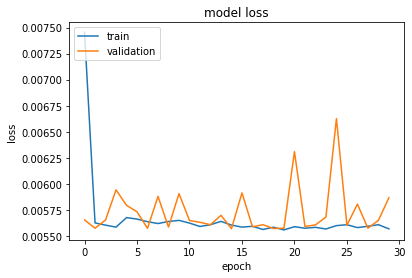

In [22]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
predictions = scaler_y.inverse_transform(predictions)
predictions

array([[19.635365 ],
       [34.583054 ],
       [16.965168 ],
       ...,
       [ 9.248923 ],
       [15.908169 ],
       [ 1.1048094]], dtype=float32)

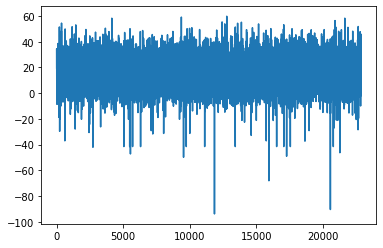

In [27]:
plt.plot(predictions)
#plt.plot(y_val)
plt.show()

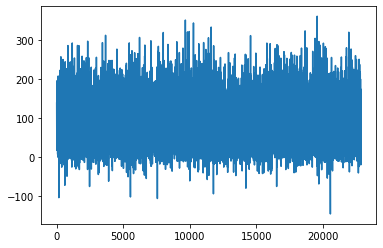

In [28]:
plt.plot(y_val)
plt.show()